# HW12 牛顿法和共轭梯度法

By ZincCat

需求解问题
$f(x) = 100(x_2-x_1^2)^2+(1-x_1)^2$

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import time
# 设置变量初值
x = np.array([-2, 2], dtype=np.float64)

In [2]:
# 定义一些辅助函数

def f(x):
    # 计算函数值
    return 100*(x[1]-x[0]*x[0])*(x[1]-x[0]*x[0])+(1-x[0])*(1-x[0])

def gradient_f(x):
    # 计算函数梯度
    return np.array([-400*x[0]*(x[1]-x[0]*x[0]) + 2*x[0] - 2, 200*(x[1] - x[0]*x[0])])

def hessian_f(x):
    # 计算函数Hessian矩阵
    return np.array([[1200*x[0]*x[0] - 400*x[1] + 2, -400*x[0]], [-400*x[0], 200]])

def r_f(x):
    # 将函数拆解为r
    return np.array([10*(x[1]-x[0]*x[0]), 1-x[0]])

def jacobi_f(x):
    # 计算r的Jacobi矩阵
    return np.array([[-20*x[0], 10], [-1, 0]])

### 牛顿法

In [3]:
def newton(x, mode, alpha=0.3, beta=0.77, eta=1e-5):
    # 牛顿法
    # 输入目前x取值, 下降模式('damped_newton'或'guass_newton'), backtrack线搜索所用参数alpha, beta(如使用damped newton) 
    # 输出下降后x取值
    t = 1.0
    value = f(x)
    if mode == 'damped':
        # damped_newton
        H = hessian_f(x)
        g = gradient_f(x)
        d = -np.linalg.solve(H, g)
        while f(x + t*d) > value + alpha*t*np.dot(g, d):
            t *= beta
        x += t*d
    elif mode == 'gauss':
        # guass_newton
        J = jacobi_f(x)
        r = r_f(x)
        d = -np.linalg.solve(J.T@J, J.T) @ r
        x += d
    return x

In [8]:
maxIter = 1000  # 最大迭代次数
eta = 1e-5
alpha=0.3
beta=0.77
values = []  # 记录某一时间步下函数值, 用于绘图
steplist = []  # 记录时间步, 用于绘图
timelist = []
Plot = True  # 是否绘图, 请保证此时alpha, beta均为单一取值
timestep = 0
x = np.array([-2, 2], dtype=np.float64)
start_time = time.perf_counter()
while True:
    # value = f(x)
    # print("Iteration:", timestep, "Error:", value, "x:", x)
    if Plot:
        values.append(f(x))
        steplist.append(timestep)
        timelist.append(1000*(time.perf_counter() - start_time))
    grad = gradient_f(x)
    grad_norm = np.linalg.norm(grad)
    if grad_norm < eta or timestep > maxIter:
        break
    x = newton(x, mode='gauss', alpha=alpha, beta=beta, eta=eta)
    timestep += 1

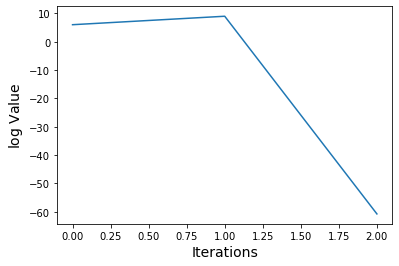

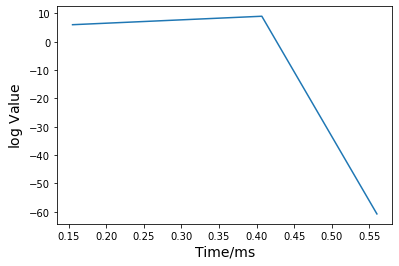

In [10]:
# 绘图
if Plot:
    # log(f − p^*) versus iteration
    plt.plot(steplist, np.log(values))
    plt.xlabel('Iterations', fontsize=14)
    plt.ylabel('$\log$ Value', fontsize=14)
    # plt.savefig('damped alpha'+str(alpha)+'beta'+str(beta)+'step.pdf')
    plt.savefig('gauss value-step.pdf')
    plt.show()

    # log(f − p^*) versus running time
    plt.plot(timelist, np.log(values))
    plt.xlabel('Time/ms', fontsize=14)
    plt.ylabel('$\log$ Value', fontsize=14)
    # plt.savefig('damped alpha'+str(alpha)+'beta'+str(beta)+'time.pdf')
    plt.savefig('gauss value-time.pdf')
    plt.show()

### 共轭梯度法

In [11]:
def conjugate_descent(x, d, alpha=0.4, beta=0.77, mode='pr'):
    # 共轭梯度下降函数
    # 输入目前x取值, 下降方向, 线搜索所需参数alpha, beta, 下降模式
    # 输出下降后x取值, 步长t
    finished = False
    g = gradient_f(x)
    alpha_k = 1.0 # for backtrack line search
    value = f(x)
    while f(x + alpha_k*d) > value + alpha*alpha_k*np.dot(g, d):
        alpha_k *= beta
    x_new = x + alpha_k*d
    g_new = gradient_f(x_new)
    beta_k = 0
    if np.linalg.norm(g_new) < eta:
        finished = True
        return x_new, d, finished
    if mode == 'pr': # Polak-Ribiere
        beta_k = np.dot(g_new, g_new - g)/np.dot(g, g)
    elif mode == 'hs': # Hestenes-Stiefel
        beta_k = np.dot(g_new, g_new - g)/np.dot(d, g_new - g)
    elif mode == 'fr': # Fletcher-Reeves
        beta_k = np.dot(g_new, g_new)/np.dot(g, g)
    d_new = beta_k * direction - g_new
    return x_new, d_new, finished

In [24]:
alpha=0.3
beta=0.6
maxIter = 300 # 最大迭代次数
eta = 1e-5  # 停止条件
values = []  # 记录某一时间步下函数值, 用于绘图
steplist = []  # 记录时间步, 用于绘图
timelist = []
Plot = True  # 是否绘图, 请保证此时alpha, beta均为单一取值
timestep = 0
x = np.array([-2, 2], dtype=np.float64)
finished = False
direction = -gradient_f(x)
mode = 'pr'

start_time = time.perf_counter()
while not finished:
    value = f(x)
    # print("Iteration:", timestep, "Error:", value)
    if Plot:
        values.append(f(x))
        steplist.append(timestep)
        timelist.append(1000*(time.perf_counter() - start_time))
    x, direction, finished = conjugate_descent(x, direction, alpha, beta, mode=mode)
    timestep += 1
    if timestep >= maxIter:
        break

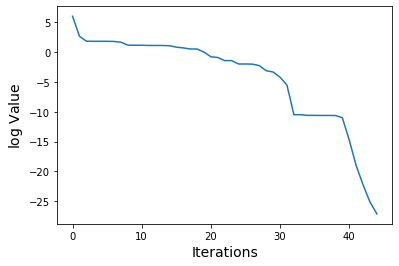

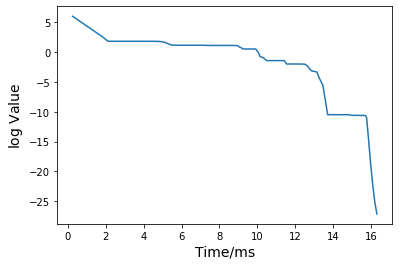

In [26]:
# 绘图
if Plot:
    # log(f − p^*) versus iteration
    plt.plot(steplist, np.log(values))
    plt.xlabel('Iterations', fontsize=14)
    plt.ylabel('$\log$ Value', fontsize=14)
    plt.savefig(mode+'alpha'+str(alpha)+'beta'+str(beta)+'value-step.pdf')
    plt.show()

    # log(f − p^*) versus running time
    plt.plot(timelist, np.log(values))
    plt.xlabel('Time/ms', fontsize=14)
    plt.ylabel('$\log$ Value', fontsize=14)
    plt.savefig(mode+'alpha'+str(alpha)+'beta'+str(beta)+'value-time.pdf')
    plt.show()

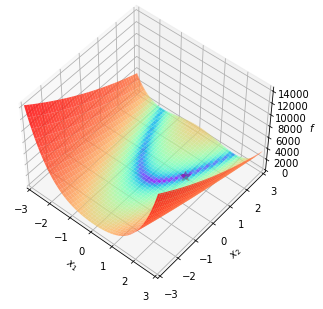

In [28]:
xmin, xmax, xstep = -3, 3, .01
ymin, ymax, ystep = -3, 3, .01
x = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
z = f(x)
zmin, zmax = np.min(z), np.max(z)
minima = np.array([1, 1]).reshape(-1, 1)
fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection='3d', elev=50, azim=-50)
ax.plot_surface(*x, z, edgecolor='none', norm = LogNorm(), alpha=.8, cmap=plt.get_cmap('rainbow'))
ax.plot(*minima, f(minima), 'r*', markersize=10)


ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$f$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
plt.savefig('12func.pdf')
plt.show()